# LAB 1

In [6]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import time as time
import operator
rand.seed()

## GLOBAL CONSTANTS

In [7]:
# grid world dimensions
length = 7
width = 7

#list all possible states, which are combinations of positions x, y, and a direction to be facing
states = [(x,y,heading) for x in range(length+1) for y in range(width+1) for heading in range(12)]
num_states = len(states)

#lists all possible actions, so combinations of (translation direction, rotation direction)
actions = [(0,0),(1,0),(1,1),(1,-1),(-1,-1),(-1,0),(-1,1)]
num_actions = len(actions)

#Probability of pre-rotation error
error_probability = 0.0

#Discount factor to be used in iterations
discount_factor = 0.9

#Initial state for all simulations
initial_state = (1,6,6)

#Target destination
goal = np.array([5,6])

## Q1

1. The variable `states` holds all possible states.  There are $N_S = 7\times 7\times 12$ states.

2. The variable `actions` holds all possible actions.  There are $N_A = 7$ actions. ($A = \{-1,0,1\}\times\{-1,0,1\} \setminus (0,\pm 1)$)

3. The function `state_probability` computes $P(s,a,s')$.  This is made simpler by the fact that given an initial state $s\in S$, and action $a\in A$, there are only three states which have nonzero probability--those corresponding to:
  * Evolving state $s$ with action $a$ when there is no prerotation error. (With probability $2-p_e$)
  * Evolving state $s$ with action $a$ when there is a positive prerotation error. (With probability $p_e$)
  * Evolving state $s$ with action $a$ when there is a negative prerotation error. (With probability $p_e$)
We can then take advantage of the law of total probability, which states:

\begin{align}
P(s_{t+1} = s' \mid s_t,a_t) &= P(s_{t+1} = s' \mid s_t,a_t,e_+)p_e + P(s_{t+1} = s' \mid s_t,a_t,e_-)p_e + P(s_{t+1} = s' \mid s_t,a_t,no~error)(1-2*p_e)
\end{align}

So, given a state $s$ and action $a$, we can evolve the state $s$ in these three ways, and return the probabilities of each state.  (Exactly this is done later in the function `evolve_option`.)
If any of these "evolved states" are identical, this is fine, we may simply return the sum of probabilities associated to each evolved state.  In other words, if two evolutions of $s$ are the same, then the total probability of going to this state is their sum.

4. To draw from the mass function described by these three states, we can consider dividing the interval $[0,1]\subset\mathbb{R}$ into three portions equal to the corresponding probabilities of each evolved state (three total).  Then, we may draw a random number $x\in[0,1]$ and compute:

\begin{align}
state(x) &= \begin{cases}
\text{state evolved with no rotation error}& 0\leq x \leq 1-2p_e \\
\text{state evolved with positive rotation error}& 1-2p_e < x \leq 1-p_e \\
\text{state evolved with negative rotation error}& 1-p_e < x \leq 1
\end{cases}
\end{align}

This is then guaranteed to follow the correct distribution, provided $x$ is drawn uniformly from $[0,1]$.

In [8]:
def heading_to_direction(heading):
    num = ((heading+1)%12)/3
    if num < 1:
        return (0,1)
    elif 1 <= num <2:
        return (1,0)
    elif 2 <= num <3:
        return (0,-1)
    elif 3 <= num < 4:
        return (-1,0)
    
def evolve_state(state,action):
    global length
    global width
    cardinal_direction = heading_to_direction(state[2]) # which way will I move?
    x = state[0] + action[0]*cardinal_direction[0]
    y = state[1] + action[0]*cardinal_direction[1]
    if (x < 0 or x > width): #undo step action if moves you out
        x = state[0]
    if (y < 0 or y > length): #undo step action if moves you out
        y = state[1]
    final_state = (x,y,(state[2]+action[1])%12)
    return final_state

def state_probability(initial_state, final_state, action, error_probability):
    # you will always stay still if you ask to
    if initial_state == final_state and action == (0,0):
        return 1.0
    
    error_state_plus = (initial_state[0],initial_state[1],(initial_state[2]+1)%12)
    error_state_minus = (initial_state[0],initial_state[1],(initial_state[2]-1)%12)
    
    probability = 0.0
    if final_state == evolve_state(error_state_minus,action):
        probability += error_probability
    if final_state == evolve_state(error_state_plus,action):
        probability += error_probability
    if final_state == evolve_state(initial_state,action):
        probability += 1.0 - 2.0*error_probability
    
    return probability

def transition_me(initial_state,action,error_probability):
    a = rand.random()
    if 0 <= a <= error_probability:
        state = evolve_state((initial_state[0],initial_state[1],(initial_state[2]+1)%12),action)
    elif a <= error_probability*2.0 :
        state = evolve_state((initial_state[0],initial_state[1],(initial_state[2]-1)%12),action)
    else :
        state = evolve_state(initial_state,action)
    return (state)

## Q2

1. Here we define the reward function $R(s,a,s')$.  However, in this scenario, the action taken and previous state do not matter, so $R:S\rightarrow \mathbb{R}$.  Given we represent $S$ as a tuple with $s\in S$ as $s = (s_x,s_y,s_h)$, we can directly define our reward:

\begin{align}
R(s) = R((s_x,s_y,s_h)) &= \begin{cases}
-100 & s_x~\%~W=0\text{ or }s_y~\%~L=0 \\
-10 & s_x = 3\text{ and }4\leq s_y \leq 6 \\
1 & s_x = 5 \text{ and }s_y = 6 \\
0 & \text{otherwise}
\end{cases}
\end{align}

In [9]:
def reward(state):
    global length
    global width
    if not((state[0] % width) and (state[1] % length)):
        return -100.0
    elif (4 <= state[1] <= 6) and state[0] == 3:
        return -10.0
    elif state[0] == 5 and state[1] == 6:
        return 1.0
    else:
        return 0.0

## Q3

As a naive initial $\pi_0$ 

1. Because the policy $\pi$ is a mapping from states to actions (i.e. $\pi:S\rightarrow A$), we can directly represent this mapping using a dictionary in Python.  Dictionaries map given $keys$ to particular $values$, both of which can be almost any arbitrary data type.  For $\pi$, the keys will be states (which are 3-tuples), and the values will be actions (which are 2-tuples).  We generate this dictionary here using our `initial_policy` function and store it in the dictionary  `initial_policy`.  These are named the same but Python lets us lazily overload the operator.

In [39]:
def initial_policy(state,goal):
    pos = np.array([state[0],state[1]])
    diff = goal - pos
    if not any(diff):
        return (0,0)
    diff = diff/np.linalg.norm(diff) #normalized vector pointing to goal

    heading_angle = np.array([np.sin((np.pi/6.0)*state[2]),np.cos(np.pi*state[2]/6.0)]) #normalized vector pointing in heading
    action_translate = np.sign(np.dot(diff,heading_angle))
    if action_translate == 0: # robot is facing perpendicular direction of desired travel
        return (1,np.sign(np.cross(diff,heading_angle))) # move up.  Why not? any movement is pretty much even.
    
    one_step = evolve_state(state,(action_translate,0))
    pos = [one_step[0], one_step[1]]
    diff = goal - pos
    if not any(diff):
        action_rotate = 0
    else :
        diff = diff/np.linalg.norm(diff)
        action_rotate = np.round(np.cross(diff,heading_angle))*action_translate 
    
    return (action_translate,action_rotate)

initial_policy = {state: initial_policy(state,goal) for state in states} #map each state to its action

2. The function `simulate` takes in an initial state $s(0)$, a policy $\pi$ (as a dict), error probability $p_e\in[0,1]$, and how many steps to take in the simulation.  It returns a sequence of states as a list.  The function `plot_trajectory` plots the resulting sequence through the environment.

In [40]:
def simulate(initial_state,policy,error_probability,tsteps):
    trajectory = [initial_state]
    for i in range(tsteps):
        trajectory.append(transition_me(trajectory[i],policy[trajectory[i]],error_probability))
    return trajectory

In [48]:
def plot_trajectory(trajectory):
    global length
    global width
    headings = np.empty([len(trajectory),2])
    coordinates = np.empty([len(trajectory),2])
    for (i,state) in enumerate(trajectory):
        #if trajectory[i-1] == state:
            #break
        coordinates[i,:] = [state[0],state[1]]
        headings[i,:] = [np.sin((np.pi/6.0)*state[2]), np.cos((np.pi/6)*state[2])]
    walls = []
    for i in range(width+1):
        walls.append((0,i))
        walls.append((i,0))
        walls.append((i,width))
        walls.append((length,i))
    goal = (5,6)
    obstacles = [(3,i) for i in range(4,7)]
    size = 500
    for wall in walls:
        plt.scatter(wall[0],wall[1], marker='s', color='red', s=size)
    for obstacle in obstacles:
        plt.scatter(obstacle[0],obstacle[1],marker='s',color='yellow',s=size)
    plt.scatter(goal[0],goal[1],marker='s',color='green',s=size)
    plt.plot(coordinates[:,0],coordinates[:,1])
    plt.axis([-0.5,width+0.5,-0.5,length+0.5])
    plt.quiver(coordinates[:,0],coordinates[:,1],headings[:,0],headings[:,1])
    plt.grid()
    plt.show()

3. The following plot shows the naive policy $\pi_0$ acting on the initial state $s(0) = (1,6,6)$ with $p_e =0$.

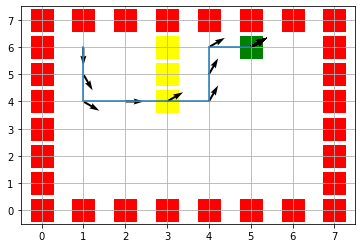

In [58]:
tsteps = 100
trajectory = simulate(initial_state,initial_policy,error_probability,tsteps)
plot_trajectory(trajectory)

4. The policy value $V^{\pi}$ is a mapping from states to values.  The official relationship is:
\begin{align}
V^{\pi}(s) &= \sum_{s'\in S}P(s,\pi(s),s')\left(R(s') + \gamma V^\pi(s') \right)
\end{align}
This recursive relationship alone isn't completely helpful for computation.  We can instead use the following algorithm steps to compute the value of the policy $V^{\pi}$.
  * Initialize $V^{\pi}_0(s) = 0$ for all $s\in S$
  * $i = 1$
  * Loop: while $V^{\pi}_{i-1} \neq V^{\pi}_{i}$:
    * $V_{i+1}^{\pi}(s) = \sum_{s'\in S}P(s,\pi(s),s')\left( R(s') + \gamma V^{\pi}_{i}(s')\right)$ for all $s\in S$
    * $i = i+1$
  * return $V_i$
  
To save on computation, we take advantage of the fact that at any state $s$ and action $a$, only three $s'\in S\s$ have nonzero probability.  The function `evolve_options` computes these states and their associated probabilities.  It is then used in the function `policy_evaluation_all_states` to run the algorithm outlined above.  Rather than waiting for exact convergence (i.e. $V^{\pi}_{i-1} \neq V^{\pi}_{i}$) we include a tolerance which stops the algorithm at 0.001 difference.

In [59]:
def evolve_options(state, action, error_probability):
    global length
    global width
    if error_probability:
        heading_error_p = (state[2]+1)%12
        heading_error_m = (state[2]-1)%12

        direction_no_error = heading_to_direction(state[2]) # which way will I move?
        direction_error_p = heading_to_direction(heading_error_p)
        direction_error_m = heading_to_direction(heading_error_m)

        x_no_error = state[0] + action[0]*direction_no_error[0]
        y_no_error = state[1] + action[0]*direction_no_error[1]

        x_error_p = state[0] + action[0]*direction_error_p[0]
        y_error_p = state[1] + action[0]*direction_error_p[1]

        x_error_m = state[0] + action[0]*direction_error_m[0]
        y_error_m = state[1] + action[0]*direction_error_m[1]

        if (x_no_error < 0 or x_no_error > width): #undo step action if moves you out
            x_no_error = state[0]
        if (y_no_error < 0 or y_no_error > length): #undo step action if moves you out
            y_no_error = state[1]

        if (x_error_p < 0 or x_error_p > width): #undo step action if moves you out
            x_error_p = state[0]
        if (y_error_p < 0 or y_error_p > length): #undo step action if moves you out
            y_error_p = state[1]

        if (x_error_m < 0 or x_error_m > width): #undo step action if moves you out
            x_error_m = state[0]
        if (y_error_m < 0 or y_error_m > length): #undo step action if moves you out
            y_error_m = state[1]

        state_no_error = (x_no_error,y_no_error,(state[2]+action[1])%12)
        state_error_p = (x_error_p,y_error_p,(heading_error_p + action[1])%12)
        state_error_m = (x_error_m,y_error_m,(heading_error_m + action[1])%12)

        probabilities = {state_no_error : 1.0}

        if state_error_p != state_no_error:
            probabilities[state_no_error] -= error_probability
            probabilities.update({state_error_p : error_probability})
        if state_error_m != state_no_error:
            probabilities[state_no_error] -= error_probability
            probabilities.update({state_error_m : error_probability})
        return probabilities
    else:
        direction = heading_to_direction(state[2])
        x_no_error = state[0] + action[0]*direction[0]
        y_no_error = state[1] + action[0]*direction[1]
        if (x_no_error < 0 or x_no_error > width): #undo step action if moves you out
            x_no_error = state[0]
        if (y_no_error < 0 or y_no_error > length): #undo step action if moves you out
            y_no_error = state[1]
        return {(x_no_error,y_no_error,(state[2]+action[1])%12) : 1.0}

def policy_evaluation_all_states(policy, discount_factor, error_probability):
    diff = np.inf
    value = dict.fromkeys(policy,0)
    tol = 0.0001
    while diff > tol :
        diff = 0
        for state in policy.keys():
            old = value[state]
            new = 0
            for (finals,p) in evolve_options(state,policy[state],error_probability).items():
                new += p*(reward(finals) + discount_factor*value[finals])
            value[state] = new
            diff = max(diff,abs(old-new))
    return value

5. We then perform a policy evaluation on all possible states of our initial policy $\pi_0$, and the value of the earlier trajectory is the value at the initial state $s(0) = (1,6,6)$.

In [60]:
initial_policy_value = policy_evaluation_all_states(initial_policy,discount_factor,error_probability)

In [61]:
initial_policy_value[initial_state]

-2.507716596132412

We can even compare this value to the formulaic computation of the value, and see that it lines up.

In [63]:
initial_trajectory_value = 0
for (t,state) in enumerate(trajectory):
    initial_trajectory_value += reward(state)*discount_factor**(t-1)
print(initial_trajectory_value)

-2.507296613988874


5. The function `compute_policy` takes a given value function and computes:
\begin{align}
    \pi_{i+1}(s) &= \underset{a\in A}{\text{argmax}}\left[ \sum_{s'\in S}P(s,a,s')\left(R(s') + \gamma V_i(s')\right)\right]
\end{align}
Algorithmically it does this by using the current value function to compute the value of each action similarly to what is done for policy evaluation.

In [64]:
def compute_policy(value_all_states,state,actions,error_probability):
    V = {}
    for action in actions:
        possible_finals = evolve_options(state,action,error_probability)
        value = 0
        for (final,p) in possible_finals.items():
            value += p*(reward(final) + discount_factor*value_all_states[final])
        V.update({action : value})
    argmax_policy = max(V.items(), key=operator.itemgetter(1))[0]
    return argmax_policy

6. Policy iteration simply straps the previous two functions together, iterating:

  * Input: initial policy $\pi_0$
  * $i = 0$
  * While not converged:
    * Evaluate policy $\pi_i$, find $V^{\pi_i}$
    * Extract new policy $\pi_{i+1}$ from $V^{\pi_i}$
    * $i = i+1$
  * Return: $\pi_i$ (and $V^{\pi_i}$ if desired)

In [14]:
def policy_iteration(initial_policy,discount_factor,error_probability):
    V = policy_evaluation_all_states(initial_policy,discount_factor,error_probability)
    actions = set(initial_policy.values())
    new_policy = initial_policy
    old_policy = {}
    while old_policy != new_policy:
        for state in V.keys():
            old_policy.update({state : new_policy[state]}) # store last value
            new_policy.update({state : compute_policy(V,state,actions,error_probability)}) #store new value
        V = policy_evaluation_all_states(new_policy,discount_factor,error_probability)
    return new_policy

7. We then do this policy iteration on our initial naive policy $\pi_0$ in the scenario explored before.  We also time it, and it seems to take about 3.5 seconds.

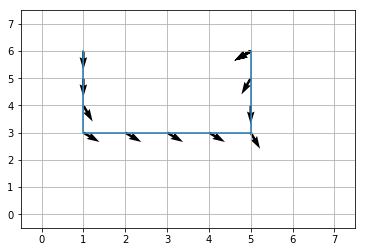

Policy computed in 3.4695749282836914 seconds


In [15]:
policy_iter_start = time.time()
policy_iter_policy = policy_iteration(initial_policy,discount_factor,error_probability)
policy_iter_time = time.time() - policy_iter_start
tsteps = 20
trajectory = simulate(initial_state,policy_iter_policy,error_probability,tsteps)
plot_trajectory(trajectory)
print("Policy computed in %s seconds" % policy_iter_time)

## Q4

1. Value iteration begins with a poor choice of $V^{\pi}$, then updates repeatedly until it settles to some $V^{\pi^*}$.  After finding this value, we can extract the optimal policy from a similar maximization as done in policy iteration.  To properly do value iteration, we have an update function `compute_value_update` which, given a state $s\in S$ computes the new largest action (and its corresponding value at the state) given the current value function.

Value iteration is performed through the following algorithm:
  * Initialize $V_0(s) = 0$ for all $s\in S$
  * i = 0
  * $V_{i+1}(s) = \underset{a\in A}{\max}\left[\sum_{s'\in S}P(s,a,s')\left(R(s')+\gamma V_i(s')\right)\right]$
  * While $V_{i+1}(s) \neq V_i(s)$:
     * $V_{i+1}(s) = \underset{a\in A}{\max}\left[\sum_{s'\in S}P(s,a,s')\left(R(s')+\gamma V_i(s')\right)\right]$
     * $i = i+1$
  * $\pi^* = \underset{a\in A}{\text{argmax}}\left[ \sum_{s'\in S}P(s,a,s')\left(R(s') + \gamma V_i(s')\right)\right]$
  * Return $\pi^*$.

In [16]:
def compute_value_update(value_all_states,actions,state,error_probability):
    V = {}
    for action in actions:
        possible_finals = evolve_options(state,action,error_probability)
        value = 0
        for (final,p) in possible_finals.items():
            value += p*(reward(final) + discount_factor*value_all_states[final][1])
        V.update({action : value})
    (max_action,max_value) = max(V.items(), key=operator.itemgetter(1))
    return (max_action,max_value)

def value_iteration(states,actions,discount_factor,error_probability):
    new_value = dict.fromkeys(states,((1,1),0)) # initial value function with all states' value = 0
    old_value = dict.fromkeys(states,((1,0),0))
    while old_value != new_value:
        for state in states:
            old_value.update({state: new_value[state]}) # store the old value function
            new_value[state] = compute_value_update(old_value,actions,state,error_probability) #compute new value for each state
    
    policy = {}
    policy.update({state:action for (state,(action,value)) in new_value.items()})
    return policy    
    


2. We then perform value iteration on the same setup.  The time comes out to be almost twice as much as that for policy iteration, but the policies seem ultimately the same.

In [65]:
value_iter_start = time.time()
value_iter_policy = value_iteration(states,actions,discount_factor,error_probability)
value_iter_time = time.time() - value_iter_start
tsteps = 25
trajectory = simulate(initial_state,value_iter_policy,error_probability,tsteps)
plot_trajectory(trajectory)
print('Policy computed in %s seconds' % value_iter_time)

NameError: name 'value_iteration' is not defined

## Q5

1. We run the same simulations as before but with a probability of error $p_e = 0.25$.  

In [18]:
error_probability = 0.25

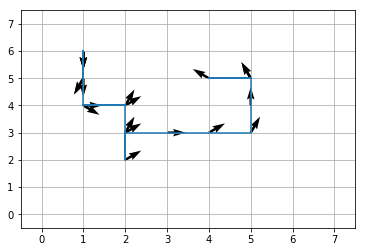

Policy computed in 10.655462741851807 seconds


In [19]:
policy_iter_start = time.time()
policy_iter_policy = policy_iteration(initial_policy,discount_factor,error_probability)
policy_iter_time = time.time() - policy_iter_start
tsteps = 20
trajectory = simulate(initial_state,policy_iter_policy,error_probability,tsteps)
plot_trajectory(trajectory)
print("Policy computed in %s seconds" % policy_iter_time)

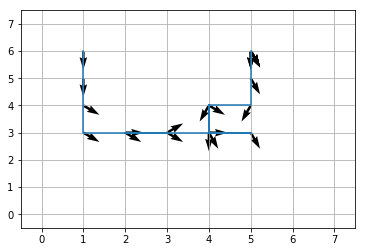

Policy computed in 19.423713207244873 seconds


In [20]:
value_iter_start = time.time()
value_iter_policy = value_iteration(states,actions,discount_factor,error_probability)
value_iter_time = time.time() - value_iter_start
tsteps = 25
trajectory = simulate(initial_state,value_iter_policy,error_probability,tsteps)
plot_trajectory(trajectory)
print('Policy computed in %s seconds' % value_iter_time)

2. We end by modifying the reward to include a positive reward if the state is $s = (4,5,6)$.  We run simulations with zero and nonzero $p_e$. 

In [66]:
def reward(state):
    global length
    global width
    if not((state[0] % width) and (state[1] % length)):
        return -100.0
    elif (4 <= state[1] <= 6) and state[0] == 3:
        return -10.0
    elif state[0] == 5 and state[1] == 6 and state[2] == 6:
        return 1.0
    else:
        return 0.0

In [67]:
error_probability = 0.0

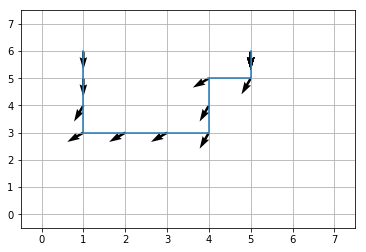

Policy computed in 6.704925060272217 seconds


In [23]:
value_iter_start = time.time()
value_iter_policy = value_iteration(states,actions,discount_factor,error_probability)
value_iter_time = time.time() - value_iter_start
tsteps = 25
trajectory = simulate(initial_state,value_iter_policy,error_probability,tsteps)
plot_trajectory(trajectory)
print('Policy computed in %s seconds' % value_iter_time)

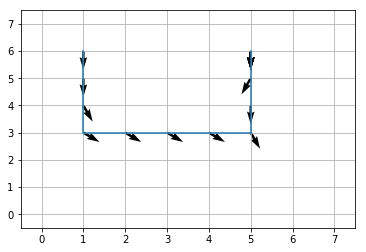

Policy computed in 6.020063877105713 seconds


In [24]:
policy_iter_start = time.time()
policy_iter_policy = policy_iteration(initial_policy,discount_factor,error_probability)
policy_iter_time = time.time() - policy_iter_start
tsteps = 20
trajectory = simulate(initial_state,policy_iter_policy,error_probability,tsteps)
plot_trajectory(trajectory)
print("Policy computed in %s seconds" % policy_iter_time)

In [25]:
error_probability = 0.25

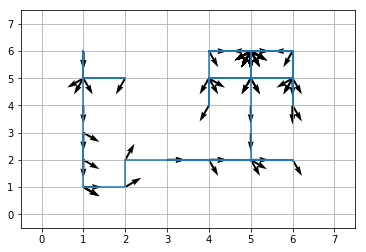

Policy computed in 21.460499048233032 seconds


In [26]:
value_iter_start = time.time()
value_iter_policy = value_iteration(states,actions,discount_factor,error_probability)
value_iter_time = time.time() - value_iter_start
tsteps = 100
trajectory = simulate(initial_state,value_iter_policy,error_probability,tsteps)
plot_trajectory(trajectory)
print('Policy computed in %s seconds' % value_iter_time)

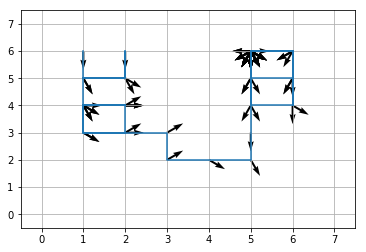

Policy computed in 10.628075122833252 seconds


In [27]:
policy_iter_start = time.time()
policy_iter_policy = policy_iteration(initial_policy,discount_factor,error_probability)
policy_iter_time = time.time() - policy_iter_start
tsteps = 100
trajectory = simulate(initial_state,policy_iter_policy,error_probability,tsteps)
plot_trajectory(trajectory)
print("Policy computed in %s seconds" % policy_iter_time)